# Introduction


This notebook is an evaluation exercise for Google Summer of Code 2020, ATLAS Autoencoders project under CERN-HSF. 

The following were the tasks assigned:
1.   Prepare an autoencoder to compress the given files (from 4 to 3 variables).
2.   Produce diifernt plots like difference between original and uncompressed variables for each entry of the dataset, divided by the original variable, reconstruction loss, etc.
3. Reverse-engineer the code that others have written and suggest them how to improve the documentation.

Deliverables:
1. Answer the following questions in the google form attached to this evaluation.
> 1. What was the most difficult thing for you while performing this this task?
> 2. How would you improve the documentation of the project?
> 3. How would you improve this network? Why?
> 4. Where else could you think of using a similar network?
2. Write a short presentation in google slides about the work that you have done to solve this challenge, you should include the plots here as well. The audience for these slides should not be computer scientists or machine learning experts, but rather general scientists, so try to give them an introduction of what you are doing and why as well as the results, based on the material you have read, and comment explicitly on what the plots are showing (e.g. does the network work well for compression based on them?).

This work was done by Swapnil Panwala, with the help of the GitHub repository, Link:https://github.com/Skelpdar/HEPAutoencoders and some tutorials!

Please find results and suggestions under the summary section.

In [24]:
# Linking the code with my Drive for easy data access
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Getting Started

It's always a good practice to understand the data on which we are working, first before actually using it. This section derives some important information and relationships from the data.

Note: There can be different relationships and evaluations of the data. This section only contains the snippets that were either very useful to get the sense of the data or were useful for the latter parts of the code.

## Understanding the data distribution

In [0]:
# Import necessaries
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

I have utilized the correlation matrix to get the correlation coefficients for different parameters, which can, in turn, help us to understand the relationships between these parameters. 

In [16]:
# Load data
train = pd.read_pickle('/___/all_jets_train_4D_100_percent.pkl')
test = pd.read_pickle('/___/all_jets_test_4D_100_percent.pkl')
n_features = len(train.loc[0])

# Normalize
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
test = (test - train_mean) / train_std

# Ploting the correlation matrix
train.corr()

,m,pt,phi,eta
m,1.000000,0.873094,-0.000435,-0.013842
pt,0.873094,1.000000,-0.003258,-0.017933
phi,-0.000435,-0.003258,1.000000,-0.004038
eta,-0.013842,-0.017933,-0.004038,1.000000


Note: Notice the high correlation coefficient for the columns m and pt. 

Let's now perform Principal component analysis (PCA), i.e. a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. This can help us to visualize the data that is in a higher dimension (here, 4) by converting it into a lower dimension (here, 3 or 2) and preserving important information about the data. 

In [11]:
from sklearn.decomposition import PCA

# Reducing to 3 dimensions
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(train)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3'])

principalDf.corr()

,principal component 1,principal component 2,principal component 3
principal component 1,1.000000e+00,-1.344767e-17,-9.162247e-18
principal component 2,-1.344767e-17,1.000000e+00,2.792613e-16
principal component 3,-9.162247e-18,2.792613e-16,1.000000e+00


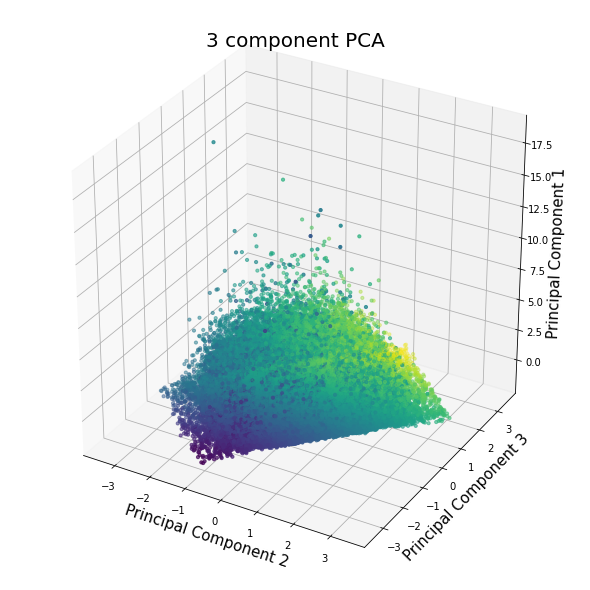

In [12]:
# Visualizing the data
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax = Axes3D(fig)
ax.set_xlabel('Principal Component 2', fontsize = 15)
ax.set_ylabel('Principal Component 3', fontsize = 15)
ax.set_zlabel('Principal Component 1', fontsize = 15)
ax.set_title('3 component PCA', fontsize = 20)
ax.scatter( principalDf['principal component 2'], principalDf['principal component 3'], principalDf['principal component 1'], c=principalDf['principal component 3'], s=10)
ax.grid()

Note: The colors are more closer to blue spectrum for higher values of Principal component 3. The data distribution is like a 3-dimesion hill with circular top. 

Let's plot it in lower dimension to a lower dimension as it would be more simpler to understand.

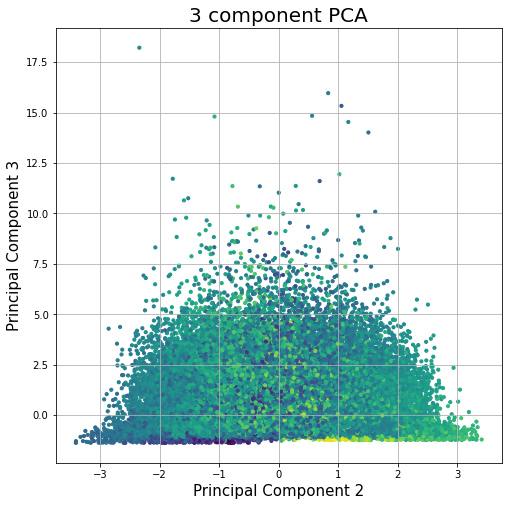

In [13]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 2', fontsize = 15)
ax.set_ylabel('Principal Component 3', fontsize = 15)
ax.set_title('3 component PCA', fontsize = 20)
ax.scatter( principalDf['principal component 2'], principalDf['principal component 1'], c=principalDf['principal component 3'], s=10)
ax.grid()

Note: The colors are more closer to blue spectrum for higher values of Principal component 3. 

In [14]:
from sklearn.decomposition import PCA

# Reducing to 3 dimensions
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(train)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf.corr()

,principal component 1,principal component 2
principal component 1,1.000000e+00,-5.987285e-17
principal component 2,-5.987285e-17,1.000000e+00


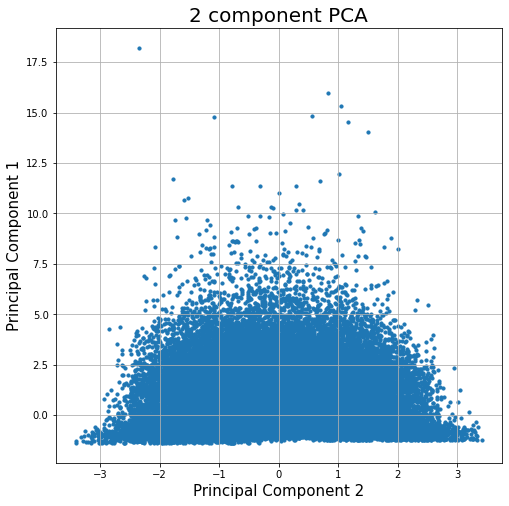

In [15]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 2', fontsize = 15)
ax.set_ylabel('Principal Component 1', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
ax.scatter(principalDf['principal component 2'], principalDf['principal component 1'], s=10, c=None)
ax.grid()

## Anomaly Analysis

In this section, we analyze different methods by which we can distinguish anomalies from the data.

### Histogram based outlier detection

In [16]:
# Install pyod if not installed
!pip install pyod

     |████████████████████████████████| 102kB 10.7MB/s 
     |████████████████████████████████| 2.1MB 41.8MB/s 
  Created wheel for pyod: filename=pyod-0.7.8-cp36-none-any.whl size=104952 sha256=ef799bffc5b32fda97e35740ea98df802cc3506d5b95ab7cf0912dbdd18be342
  Stored in directory: /root/.cache/pip/wheels/7a/72/cc/8d691190b9525ee49125be37ce231bb02ee0c71882dce4a1cd
  Created wheel for combo: filename=combo-0.1.0-cp36-none-any.whl size=42043 sha256=7510a799628293d1a6d2d124483f3eb8b5dea0f9f6425a4bec96071940b8bed3
  Stored in directory: /root/.cache/pip/wheels/00/fd/6c/8da495ef08ce61844a646df2423c2b8ecda377a89c90ecd88e
  Created wheel for suod: filename=suod-0.0.3-cp36-none-any.whl size=2166457 sha256=b48232b80add6056289f63b43e1b1866937b2a06d0685ef0ee22d9d748248e6a
  Stored in directory: /root/.cache/pip/wheels/15/56/16/6944851600a62d859c89cd11df1adecbe0b6a02f7ad713d4dd
Successfully built pyod combo suod


In [26]:
from pyod.models.hbos import HBOS
outliers_fraction = 0.01
clf = HBOS(contamination=outliers_fraction)
clf.fit(principalDf)

HBOS(alpha=0.1, contamination=0.01, n_bins=10, tol=0.5)

OUTLIERS: 1009 INLIERS: 110769


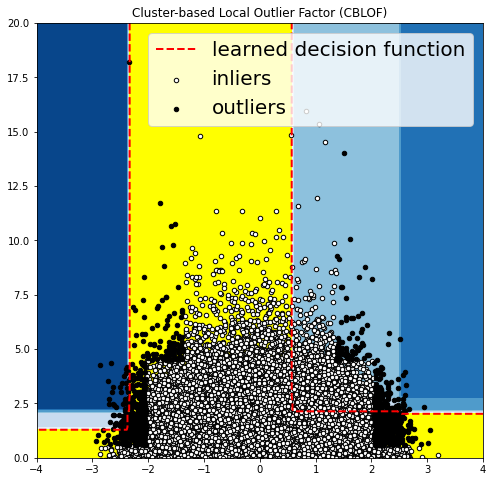

In [27]:
import matplotlib

xx , yy = np.meshgrid(np.linspace(-4, 4, 100), np.linspace(0, 20, 100))
scores_pred = clf.decision_function(principalDf) * -1
y_pred = clf.predict(principalDf)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)

plt.figure(figsize=(8, 8))

data = pd.DataFrame()
data['outlier'] = y_pred.tolist()
    
inliers_para1 = np.array(principalDf['principal component 1'][data['outlier'] == 0]).reshape(-1,1)
inliers_para2 = np.array(principalDf['principal component 2'][data['outlier'] == 0]).reshape(-1,1)
    

outliers_para1 = np.array(principalDf['principal component 1'][data['outlier'] == 1].values).reshape(-1,1)
outliers_para2 = np.array(principalDf['principal component 2'][data['outlier'] == 1].values).reshape(-1,1)
         
print('OUTLIERS:',n_outliers,'INLIERS:',n_inliers)
threshold = np.percentile(scores_pred, 100 * outliers_fraction)        
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='yellow')
b = plt.scatter(inliers_para2, inliers_para1, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_para2, outliers_para1, c='black',s=20, edgecolor='k')
       
plt.axis('tight')   
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='upper right')      
plt.xlim((-4, 4))
plt.ylim((0, 20))
plt.title('Cluster-based Local Outlier Factor (CBLOF)')
plt.show()

### Cluster based outlier detection

In [28]:
from pyod.models.cblof import CBLOF
outliers_fraction = 0.005
clf = CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=0)
clf.fit(principalDf)

CBLOF(alpha=0.9, beta=5, check_estimator=False, clustering_estimator=None,
   contamination=0.005, n_clusters=8, n_jobs=1, random_state=0,
   use_weights=False)

OUTLIERS: 559 INLIERS: 111219


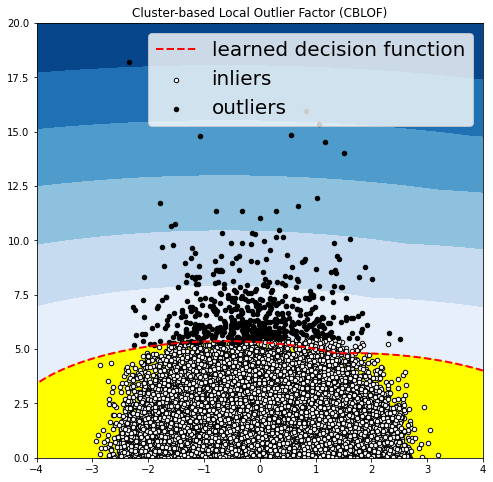

In [30]:
xx , yy = np.meshgrid(np.linspace(-4, 4, 100), np.linspace(0, 20, 100))
scores_pred = clf.decision_function(principalDf) * -1
y_pred = clf.predict(principalDf)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)

plt.figure(figsize=(8, 8))

data = pd.DataFrame()
data['outlier'] = y_pred.tolist()
    
inliers_para1 = np.array(principalDf['principal component 1'][data['outlier'] == 0]).reshape(-1,1)
inliers_para2 = np.array(principalDf['principal component 2'][data['outlier'] == 0]).reshape(-1,1)
    

outliers_para1 = np.array(principalDf['principal component 1'][data['outlier'] == 1].values).reshape(-1,1)
outliers_para2 = np.array(principalDf['principal component 2'][data['outlier'] == 1].values).reshape(-1,1)
         
print('OUTLIERS:',n_outliers,'INLIERS:',n_inliers)
threshold = np.percentile(scores_pred, 100 * outliers_fraction)        
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='yellow')
b = plt.scatter(inliers_para2, inliers_para1, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_para2, outliers_para1, c='black',s=20, edgecolor='k')
       
plt.axis('tight')   
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='upper right')      
plt.xlim((-4, 4))
plt.ylim((0, 20))
plt.title('Cluster-based Local Outlier Factor (CBLOF)')
plt.show()

### Isolation forest

In [0]:
from pylab import savefig
from sklearn.ensemble import IsolationForest

clf = IsolationForest(max_samples=900)
clf.fit(train)

pred_train = clf.predict(train)
pred_test = clf.predict(test)

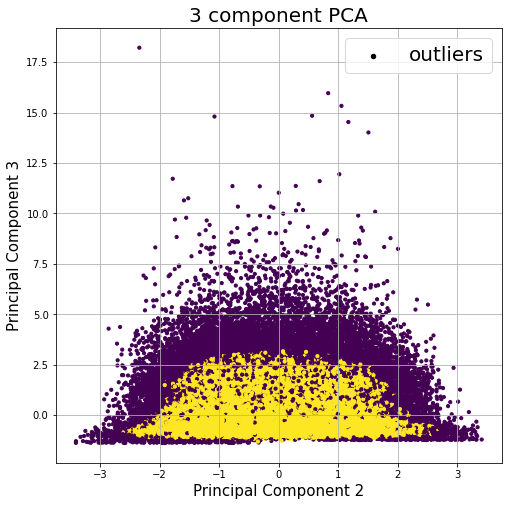

In [46]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 2', fontsize = 15)
ax.set_ylabel('Principal Component 3', fontsize = 15)
ax.set_title('3 component PCA', fontsize = 20)
ax.scatter( principalDf['principal component 2'], principalDf['principal component 1'], c=pred_train, s=10)
plt.legend([c], ['outliers'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='upper right')
ax.grid()

According to me, Isolation Forest has given better results as the predictions near edge cases are cleaner and the predictions seems to be uniform; But there are some more techniques to compare like KNN, etc.

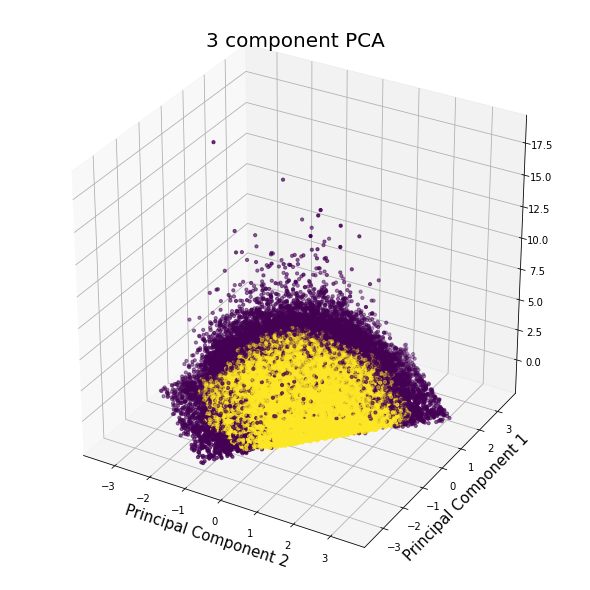

In [47]:
# Plotting in 3 dimensional space for better a understanding
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(train)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3'])

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax = Axes3D(fig)
ax.set_xlabel('Principal Component 2', fontsize = 15)
ax.set_ylabel('Principal Component 3', fontsize = 15)
ax.set_ylabel('Principal Component 1', fontsize = 15)
ax.set_title('3 component PCA', fontsize = 20)
ax.scatter( principalDf['principal component 2'], principalDf['principal component 3'], principalDf['principal component 1'], c=pred_train, s=10)
ax.grid()

# Reverse engineering the previous development

This is the implementaion of the work done in the repository: https://github.com/Skelpdar/HEPAutoencoders

## Utilities

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import basic_train, basic_data
from fastai.callbacks import ActivationStats
import fastai

import matplotlib as mpl

fastai.torch_core.defaults.device = 'cuda'

In [0]:
class AE_3D_200(nn.Module):
    def __init__(self, n_features=4):
        super(AE_3D_200, self).__init__()
        self.en1 = nn.Linear(n_features, 200)
        self.en2 = nn.Linear(200, 100)
        self.en3 = nn.Linear(100, 50)
        self.en4 = nn.Linear(50, 3)
        self.de1 = nn.Linear(3, 50)
        self.de2 = nn.Linear(50, 100)
        self.de3 = nn.Linear(100, 200)
        self.de4 = nn.Linear(200, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return 'in-200-100-50-3-50-100-200-out'

## Loading the model

In [0]:
train_x = train
test_x = test
train_y = train_x 
test_y = test_x

train_ds = TensorDataset(torch.tensor(train_x.values).float(), torch.tensor(train_y.values).float())
valid_ds = TensorDataset(torch.tensor(test_x.values).float(), torch.tensor(test_y.values).float())

def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

train_dl, valid_dl = get_data(train_ds, valid_ds, bs=256)

db = basic_data.DataBunch(train_dl, valid_dl)

model = AE_3D_200()

class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(x, y))
        return loss
loss_func = nn.MSELoss()

bn_wd = False  # Don't use weight decay fpr batchnorm layers
true_wd = True  # wd will be used for all optimizers
wd = 1e-6
learn = basic_train.Learner(data=db, model=model, loss_func=loss_func, wd=wd, callback_fns=ActivationStats, bn_wd=bn_wd, true_wd=true_wd)

In [26]:
learn.load('/___/AE_3D_200_no1cycle_trainforever')
learn.validate()

[0.5058878]

## Plotting the results

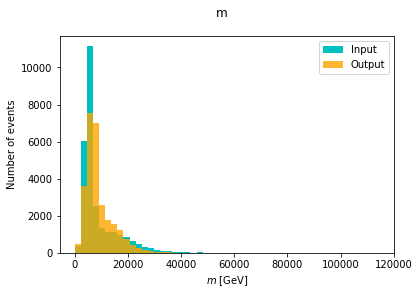

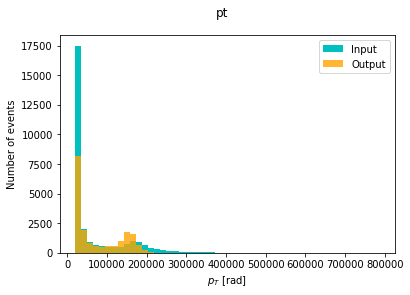

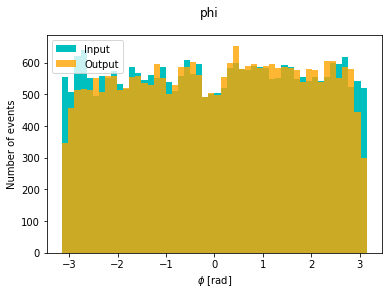

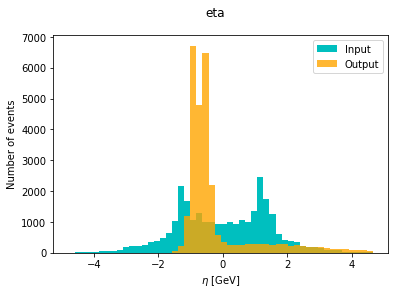

In [53]:
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$m$', r'$p_T$', r'$\phi$', r'$\eta$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

model.to('cpu')

# Histograms
idxs = (0, 100000)  # Choosing the events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values).float()
pred = model(data).detach().numpy()
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

alph = 0.8
n_bins = 50
for kk in np.arange(4):
    plt.figure(kk + 4)
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(train_x.columns[kk])
    plt.xlabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('Number of events')
    plt.legend()
    fig_name = 'trainforever_hist_%s' % train.columns[kk]

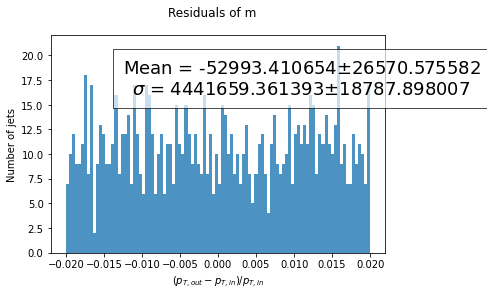

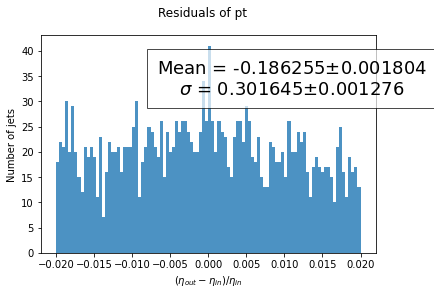

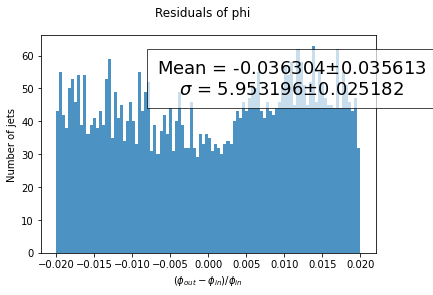

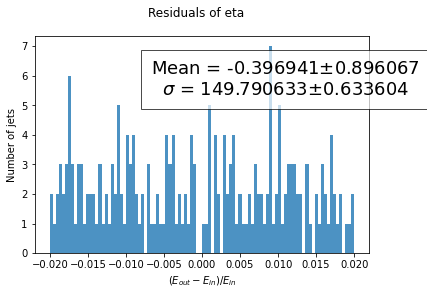

In [54]:
def std_error(x, axis=None, ddof=0):
    return np.nanstd(x, axis=axis, ddof=ddof) / np.sqrt(2 * len(x))

from scipy import stats
residual_strings = [r'$(p_{T,out} - p_{T,in}) / p_{T,in}$',
                        r'$(\eta_{out} - \eta_{in}) / \eta_{in}$',
                        r'$(\phi_{out} - \phi_{in}) / \phi_{in}$',
                        r'$(E_{out} - E_{in}) / E_{in}$']
residuals = (pred - data.detach().numpy()) / data.detach().numpy()
range = (-.02, .02)
for kk in np.arange(4):
    plt.figure()
    n_hist_pred, bin_edges, _ = plt.hist(
        residuals[:, kk], label='Residuals', linestyle=line_style[0], alpha=alph, bins=100, range=range)
    plt.suptitle('Residuals of %s' % train.columns[kk])
    plt.xlabel(residual_strings[kk])  # (train.columns[kk], train.columns[kk], train.columns[kk]))
    plt.ylabel('Number of jets')
    std = np.std(residuals[:, kk])
    std_err = std_error(residuals[:, kk])
    mean = np.nanmean(residuals[:, kk])
    sem = stats.sem(residuals[:, kk], nan_policy='omit')
    ax = plt.gca()
    plt.text(.75, .8, 'Mean = %f$\pm$%f\n$\sigma$ = %f$\pm$%f' % (mean, sem, std, std_err), bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10},
             horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=18)
    fig_name = 'trainforever_residual_%s' % train.columns[kk]

# Developing my own autoencoder network

To develop better insights about what relations our model is capable of learning, I have built different deep autoencoder networks from scratch. Also, I have tweaked these models to implement some ideas that I thought about.

## Preprocessing and Utility

In [20]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, LSTM, RepeatVector
from keras.models import Model
from keras.models import model_from_json
from keras import regularizers
import datetime
import time
import requests as req
import json
import pandas as pd
import pickle
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [21]:
# Load data
train = pd.read_pickle('/___/all_jets_train_4D_100_percent.pkl')
test = pd.read_pickle('/___/all_jets_test_4D_100_percent.pkl')
n_features = len(train.loc[0])

# Normalize
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
test = (test - train_mean) / train_std
train

,m,pt,phi,eta
132784,-0.688496,-0.607629,0.868107,0.759040
99666,-0.587358,-0.612672,-1.487534,0.117474
26629,1.051897,1.503479,-1.081401,0.773105
80473,0.788036,1.697702,-0.911068,1.813972
48229,-0.578692,-0.628716,1.619709,-0.830115
...,...,...,...,...
53491,-0.537380,-0.571190,-1.193353,1.110843
106817,0.634300,0.533333,1.351920,1.069930
61324,-0.453699,-0.576947,0.679283,1.020818
132003,-0.619830,-0.587073,-1.330767,0.765242


## Simple 4x3x4 Deep Autoencoder Network

A simple Deep Autoencoder Network that encodes the 4 dimensional input to 3 dimension and then decodes to data back to 4 dimension. I aim to use this network as a benchmark to compare different Deep Autoencoder Networks.

In [57]:
# reduce to 3 features
encoding_dim = 3

input_df = Input(shape=(4,))
encoded = Dense(encoding_dim, activation='relu')(input_df)
decoded = Dense(4, activation='sigmoid')(encoded)

autoencoder = Model(input_df, decoded)

# intermediate result
encoder = Model(input_df, encoded)

autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

autoencoder.fit(train, train,
                epochs=50,
                batch_size=64,
                shuffle=True,
                validation_data=(test, test))








Train on 111778 samples, validate on 27945 samples
Epoch 1/50





111778/111778 [==============================] - 12s 109us/step - loss: 0.7354 - val_loss: 0.6292
Epoch 2/50
111778/111778 [==============================] - 5s 46us/step - loss: 0.5709 - val_loss: 0.5559
Epoch 3/50
111778/111778 [==============================] - 5s 48us/step - loss: 0.5378 - val_loss: 0.5458
Epoch 4/50
111778/111778 [==============================] - 5s 47us/step - loss: 0.5333 - val_loss: 0.5440
Epoch 5/50
111778/111778 [==============================] - 5s 45us/step - loss: 0.5322 - val_loss: 0.5433
Epoch 6/50
111778/111778 [==============================] - 5s 46us/step - loss: 0.5318 - val_loss: 0.5430
Epoch 7/50
111778/111778 [==============================] - 5s 45us/step - loss: 0.5316 - val_loss: 0.5428
Epoch 8/50
111778/111778 [==============================] - 5s 45us/step - loss: 0.5314 - val_loss: 0.5427
Epoch 9/50
111778/111778 [==============================] - 5s 46us/step - loss

In [58]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
mae = mean_absolute_error(train,pd.DataFrame(autoencoder.predict(train)))
print("mae: %f" %(mae))
rmse=np.sqrt(mean_squared_error(train,pd.DataFrame(autoencoder.predict(train))))
print("rmse: %f" %(rmse))

mae: 0.539210
rmse: 0.728609


## Multistage 4x5x3x4 Deep Autoencoder Network

Inspiration: By adding a deeper layers before the encoder it may be possible to develop a more complex model that may have better understanding about the data thus, it can encode the data in a better way.

In [59]:
# reduce to 3 features
encoding_dim = 3

input_df = Input(shape=(4,))
decoded = Dense(5, activation='relu')(input_df)
encoded = Dense(encoding_dim, activation='relu')(decoded)
decoded2 = Dense(4, activation='sigmoid')(encoded)

autoencoder = Model(input_df, decoded2)

# intermediate result
encoder = Model(input_df, encoded)

autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

autoencoder.fit(train, train,
                epochs=50,
                batch_size=64,
                shuffle=True,
                validation_data=(test, test))

Train on 111778 samples, validate on 27945 samples
Epoch 1/50
111778/111778 [==============================] - 6s 54us/step - loss: 0.6482 - val_loss: 0.5622
Epoch 2/50
111778/111778 [==============================] - 6s 54us/step - loss: 0.5410 - val_loss: 0.5468
Epoch 3/50
111778/111778 [==============================] - 6s 53us/step - loss: 0.5339 - val_loss: 0.5442
Epoch 4/50
111778/111778 [==============================] - 6s 53us/step - loss: 0.5324 - val_loss: 0.5435
Epoch 5/50
111778/111778 [==============================] - 6s 52us/step - loss: 0.5318 - val_loss: 0.5429
Epoch 6/50
111778/111778 [==============================] - 6s 52us/step - loss: 0.5314 - val_loss: 0.5427
Epoch 7/50
111778/111778 [==============================] - 6s 53us/step - loss: 0.5311 - val_loss: 0.5424
Epoch 8/50
111778/111778 [==============================] - 6s 52us/step - loss: 0.5309 - val_loss: 0.5421
Epoch 9/50
111778/111778 [==============================] - 6s 53us/step - loss: 0.5307 - val

In [60]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
mae = mean_absolute_error(train,pd.DataFrame(autoencoder.predict(train)))
print("mae: %f" %(mae))
rmse=np.sqrt(mean_squared_error(train,pd.DataFrame(autoencoder.predict(train))))
print("rmse: %f" %(rmse))

mae: 0.535905
rmse: 0.727286


There was a little increase in the accuracy (loss: 0.5290) when compared to Simple 4x3x4 Deep Autoencoder Network (loss: 0.5309), although it is still less than the previous work (loss: 0.5058).

## Reduced 2x1x2 Deep Autoencoder Network

In [22]:
# Ploting the correlation matrix
train.corr()

,m,pt,phi,eta
m,1.000000,0.873094,-0.000435,-0.013842
pt,0.873094,1.000000,-0.003258,-0.017933
phi,-0.000435,-0.003258,1.000000,-0.004038
eta,-0.013842,-0.017933,-0.004038,1.000000


Inspiration: On analyzing this correlation matrix, we can develop the inference that columns m and pt are highly correlated with each other and the other features i.e. phi and eta are not at all correlated with any other feature. So, when we generate a relationship between all of the above features, (by using an autoencoder network) there may be a higher contribution in the loss as these parameters are not at all correlated and we are trying to generate a relationship. So, what if we try to just encode m and pt (i.e. 2 dimensions to 1 dimension) and keep phi and eta as it is?

In [52]:
# Load data
train = pd.read_pickle('/___/all_jets_train_4D_100_percent.pkl')
test = pd.read_pickle('/___/all_jets_test_4D_100_percent.pkl')
n_features = len(train.loc[0])

# Normalize
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
test = (test - train_mean) / train_std
train = train.reset_index().drop(['index','phi','eta'],axis = 1)
test = test.reset_index().drop(['index','phi','eta'],axis = 1)
test

,m,pt
0,-0.533282,-0.581905
1,-0.472437,-0.609328
2,-0.498829,-0.570312
3,0.697978,1.984290
4,-0.754120,-0.566174
...,...,...
27940,3.085881,2.459298
27941,-0.418174,-0.539298
27942,-0.551680,-0.561699
27943,-0.176735,-0.392414


In [53]:
# reduce to 1 feature
encoding_dim = 1

input_df = Input(shape=(2,))
encoded = Dense(encoding_dim, activation='relu')(input_df)
decoded = Dense(2, activation='sigmoid')(encoded)

autoencoder = Model(input_df, decoded)

# intermediate result
encoder = Model(input_df, encoded)

autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

autoencoder.fit(train, train,
                epochs=35,
                batch_size=64,
                shuffle=True,
                validation_data=(test, test))

Train on 111778 samples, validate on 27945 samples
Epoch 1/35
111778/111778 [==============================] - 5s 46us/step - loss: 0.7212 - val_loss: 0.5753
Epoch 2/35
111778/111778 [==============================] - 5s 45us/step - loss: 0.5228 - val_loss: 0.5334
Epoch 3/35
111778/111778 [==============================] - 5s 45us/step - loss: 0.5073 - val_loss: 0.5296
Epoch 4/35
111778/111778 [==============================] - 5s 43us/step - loss: 0.5054 - val_loss: 0.5287
Epoch 5/35
111778/111778 [==============================] - 5s 42us/step - loss: 0.5049 - val_loss: 0.5284
Epoch 6/35
111778/111778 [==============================] - 5s 44us/step - loss: 0.5046 - val_loss: 0.5282
Epoch 7/35
111778/111778 [==============================] - 5s 43us/step - loss: 0.5044 - val_loss: 0.5281
Epoch 8/35
111778/111778 [==============================] - 5s 42us/step - loss: 0.5044 - val_loss: 0.5280
Epoch 9/35
111778/111778 [==============================] - 5s 43us/step - loss: 0.5043 - val

## Testing and Results

In [54]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
encoded_test = pd.DataFrame(autoencoder.predict(train))
result = pd.DataFrame(encoder.predict(train))

train = pd.read_pickle('/___/all_jets_train_4D_100_percent.pkl')
train = (train - train_mean) / train_std
train = train.reset_index().drop(['index'],axis = 1)

encoded = encoded_test
encoded['phi'] = train['phi']
encoded['eta'] = train['eta']
result['phi'] = train['phi']
result['eta'] = train['eta']

mae = mean_absolute_error(train,encoded)
print("mae: %f" %(mae))
rmse=np.sqrt(mean_squared_error(train,encoded))
print("rmse: %f" %(rmse))

mae: 0.280014
rmse: 0.501992


So, what has just happened?

While training our Reduced 2x1x2 Deep Autoencoder Network we got a loss: 0.5040 which is a little better than the previous work (loss: 0.5058). However, when we calculate the overall loss of the network it would result in loss: 0.2800 as the features, phi and eta would also be considered in the calculation and their values are identical. 

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Side-by-Side Histogram of Encoded and original data for m')

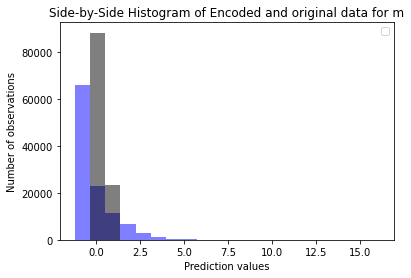

In [29]:
# Assign colors for original and encoded data
colors = ['blue', 'yellow']
names = ['Original', 'Encoded']
         
# Make the histogram
_, bins, _ = plt.hist(train['m'], bins=20 ,alpha = 0.5, color = 'blue')
_ = plt.hist(encoded[0], bins=bins, alpha=0.5, color = 'black')

# Plot formatting
plt.legend()
plt.xlabel('Prediction values')
plt.ylabel('Number of observations')
plt.title('Side-by-Side Histogram of Encoded and original data for m')

Note: Notice our model is unable to predict negative values. I guess we can solve this by keeping the normalized data positive (not subtracting the mean)

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Side-by-Side Histogram of Encoded and original data')

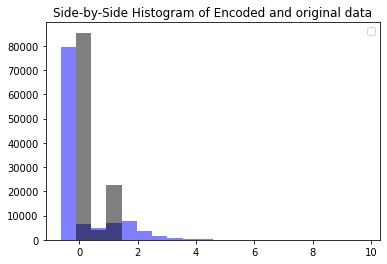

In [58]:
# Make the histogram
_, bins, _ = plt.hist(train['pt'], bins=20 ,alpha = 0.5, color = 'blue')
_ = plt.hist(encoded[1], bins=bins, alpha=0.5, color = 'black')

# Plot formatting
plt.legend()
plt.xlabel('Prediction values')
plt.ylabel('Number of observations')
plt.title('Side-by-Side Histogram of Encoded and original data for pt')

In [46]:
encoded = pd.DataFrame()
encoded['m'] = (encoded_test[0]*train_std['m'])+train_mean['m']
encoded['pt'] = (encoded_test[1]*train_std['pt'])+train_mean['pt']
encoded

,m,pt
0,8944.822266,64464.867188
1,8944.822266,64464.867188
2,16235.275391,134296.484375
3,16181.728516,134271.390625
4,8944.822266,64464.867188
...,...,...
111773,8945.664062,64467.140625
111774,12287.462891,120792.375000
111775,8947.023438,64471.238281
111776,8944.822266,64464.867188


In [47]:
original = pd.DataFrame()
original['m'] = (train['m']*train_std['m'])+train_mean['m']
original['pt'] = (train['pt']*train_std['pt'])+train_mean['pt']
original

,m,pt
0,3831.839355,22000.609375
1,4582.417480,21648.210938
2,16747.765625,169514.281250
3,14789.586914,183085.609375
4,4646.724121,20527.130859
...,...,...
111773,4953.317871,24546.789062
111774,13648.668945,101725.289062
111775,5574.332520,24144.490234
111776,4341.430664,23436.962891


In [48]:
temp = abs(1 - encoded/original)
temp = temp.replace(np.inf, np.nan).dropna(axis=0)
temp

,m,pt
0,1.334342,1.930140
1,0.951988,1.977838
2,0.030601,0.207757
3,0.094130,0.266620
4,0.924974,2.140471
...,...,...
111773,0.805994,1.626296
111774,0.099732,0.187437
111775,0.605039,1.670226
111776,1.060340,1.750564


Text(0.5, 1.0, '|original value - encoded value|/original value VS n for m')

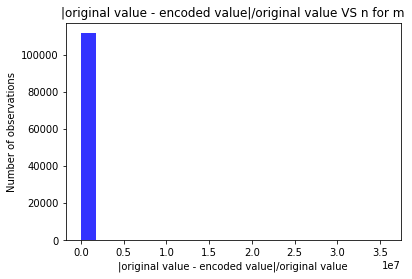

In [42]:
_ = plt.hist(temp['m'], bins=20, color = 'blue', alpha = 0.8)
plt.xlabel('|original value - encoded value|/original value')
plt.ylabel('Number of observations')
plt.title('|original value - encoded value|/original value VS n for m')

Text(0.5, 1.0, '|original value - encoded value|/original value VS n for pt')

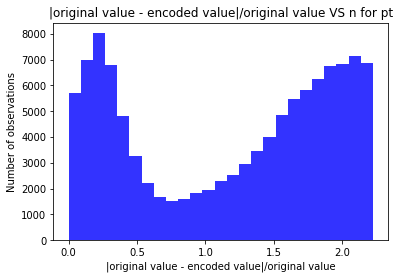

In [45]:
_ = plt.hist(temp['pt'], bins=25, color = 'blue', alpha = 0.8)
plt.xlabel('|original value - encoded value|/original value')
plt.ylabel('Number of observations')
plt.title('|original value - encoded value|/original value VS n for pt')

In [55]:
result.memory_usage()

Index       128
0        447112
phi      894224
eta      894224
dtype: int64

In [56]:
train.memory_usage()

Index       128
m        894224
pt       894224
phi      894224
eta      894224
dtype: int64

In [60]:
print('Compression ratio:',sum(train.memory_usage())/sum(result.memory_usage()))

Compression ratio: 1.5999656481584192


# *Summary*

*   How to further improve this network?

The following ways could be explored to further improve the accuracy of the network:

1.   ***Using positive normalisation technique:*** On studying  the results carefully, you will notice that the 2x1x2 Reduced DANN Architecture has not correctly predicted any negative values. So, the model is not able to learn negative features. We may solve this problem by not subtracting the mean from the data. We have originally used the formula,<br>
> Normalized data(i) = (data(i) - data_mean) / data_standard_deviation<br>
Now,<br>
> Normalized data(i) = data(i) / data_standard_deviation<br>

2.   ***Hybrid Network:*** A Hybrid network could be generated using any two or all of the following networks, i.e., Fastai AE 3D 200, 4x5x3x4 Multistage DANN Architecture, and 2x1x2 Reduced DANN Architecture. It may have a better performance.<br>

3. ***Testing different hyper-parameters:*** More networks could be generated by testing different combinations of hyper-parameters like, loss function, activation function, no. and type of layer, etc.. There is a possibility of achieving better results.

*   MSE Comparison of the discussed networks:
1. Fastai AE 3D 200 (Previous work)
> MSE: 0.5058
2. 4x3x4 DANN Architecture
> MSE: 0.5309
3. 4x5x3x4 Multistage DANN Architecture
> MSE: 0.5290
4. 2x1x2 Reduced DANN Architecture
> MSE: 0.2520


